In [24]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
L = 1.0            # Length of the box
gamma = 1         # Variational parameter for interaction strength
epsilon = 1e-2     # Small offset to avoid division by zero
N_steps = 10000    # Number of Monte Carlo steps
delta = 0.2        # Step size for Metropolis moves
m = 1.0            # Mass of particles
hbar = 1.0         # Planck's constant
q1, q2 = 1.0, 1.0  # Charges of particles

In [12]:
#Define the psi trial function
def psi_T(x1, x2, gamma):
    #if x1 <= 0 or x1 >= L or x2 <= 0 or x2 >= L:
     #    return 0  # Wave function vanishes at boundaries
    return np.sin(np.pi * x1 / L) * np.sin(np.pi * x2 / L) * np.exp(-gamma / (np.abs(x1 - x2) + epsilon))


In [25]:
#Use finite difference to calculate the second derivative for the kinetic energy term:
def second_derivative(func, x, h=1e-5):
    return (func(x + h) - 2 * func(x) + func(x - h)) / h**2

# Calculate the local energy term
def local_energy(x1, x2, gamma):
    psi = psi_T(x1, x2, gamma)
    # Second derivatives
    #use lambda to create a local variable, to be able to use partial differentation.
    d2_psi_x1 = second_derivative(lambda x: psi_T(x, x2, gamma), x1)
    d2_psi_x2 = second_derivative(lambda x: psi_T(x1, x, gamma), x2)

    # Kinetic energy
    kinetic_energy = -hbar**2 / (2 * m) * (d2_psi_x1 + d2_psi_x2) / psi

    #Potential energy
    potential_energy = q1 * q2 / (abs(x1 - x2) + epsilon)

    return kinetic_energy + potential_energy


In [33]:
# Metropolis sampling

def mcs(gamma):
    x1,x2 = 0.2,0.8 #starting positions
    #empty arrays for energies and sample points
    energies = []
    accepted_steps = 0
    x1_arr = np.array([])
    x2_arr = np.array([])
    
    for step in range(N_steps):
        # Propose new positions
        x1_new = x1 + delta * (np.random.rand() - 0.5)
        x2_new = x2 + delta * (np.random.rand() - 0.5)
    
        # Ensure positions stay in the box
        if x1_new <= 0 or x1_new >= L or x2_new <= 0 or x2_new >= L:
            continue
    
        #The Metropolis acceptance criterion
        psi_old = psi_T(x1, x2, gamma)
        psi_new = psi_T(x1_new, x2_new, gamma)
        #use min function to easily check the criterion
        A = min(1, (psi_new / psi_old)**2) if psi_old > 0 else 1
        #If the criterion is met, accept the new positions and calculate local Energy:
        if np.random.rand() < A:
            x1, x2 = x1_new, x2_new
            accepted_steps += 1
            energies.append(local_energy(x1, x2, gamma))
            np.append(x1_arr,x1)
            np.append(x2_arr,x2)
    #return the average of all energies:
    return np.mean(energies)
    


In [35]:
#Make a for loop that runs the simulation 100 times,
n = np.linspace(0,100,100)
E0 = []
for i in n:
   E0.append(mcs(gamma))

In [49]:
#Calculating the mean and variance of the 100 simulations

E0_mean = np.mean(E0)
E0_var = np.var(E0)

print("The mean value is: " + str(E0_mean) + " and the variance is: " + str(E0_var))

The mean value is: 38.39874279435399 and the variance is: 0.29033759760236266
Analytical Energy: 9.869604
Monte Carlo Energy: 9.869604


In [ ]:
#Now to check if the algorith behaves well when there is no interaction. 

# Analytical energy for non-interacting case
L = 1.0  # Box length
m = 1.0  # Particle mass
hbar = 1.0  # Reduced Planck's constant
E_analytical = 2 * (hbar**2 * np.pi**2 / (2 * m * L**2))  # Two particles

#Define new local energy with gamma = 0, and no potential energy
gamma =0 

def local_energy(x1, x2, gamma):
    psi = psi_T(x1, x2, gamma)
    # Second derivatives
    #use lambda to create a local variable, to be able to use partial differentation.
    d2_psi_x1 = second_derivative(lambda x: psi_T(x, x2, gamma), x1)
    d2_psi_x2 = second_derivative(lambda x: psi_T(x1, x, gamma), x2)

    # Kinetic energy
    kinetic_energy = -hbar**2 / (2 * m) * (d2_psi_x1 + d2_psi_x2) / psi

    #Potential energy
    potential_energy = q1 * q2 / (abs(x1 - x2) + epsilon)

    return kinetic_energy

#Define the psi trial function
def psi_T(x1, x2, gamma):
    #if x1 <= 0 or x1 >= L or x2 <= 0 or x2 >= L:
     #    return 0  # Wave function vanishes at boundaries
    return np.sin(np.pi * x1 / L) * np.sin(np.pi * x2 / L) * np.exp(-gamma / (np.abs(x1 - x2) + epsilon))

#calculate monte carlo

E_monte_carlo = mcs(gamma)

# Compare energies
print(f"Analytical Energy: {E_analytical:.6f}")
print(f"Monte Carlo Energy: {E_monte_carlo:.6f}")

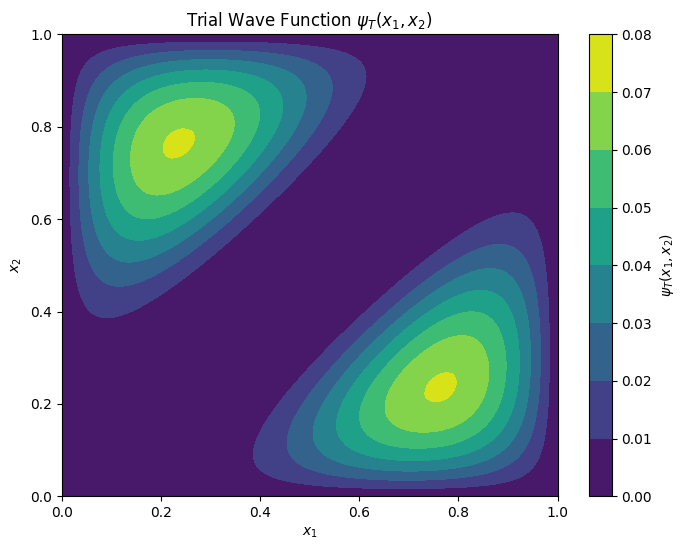

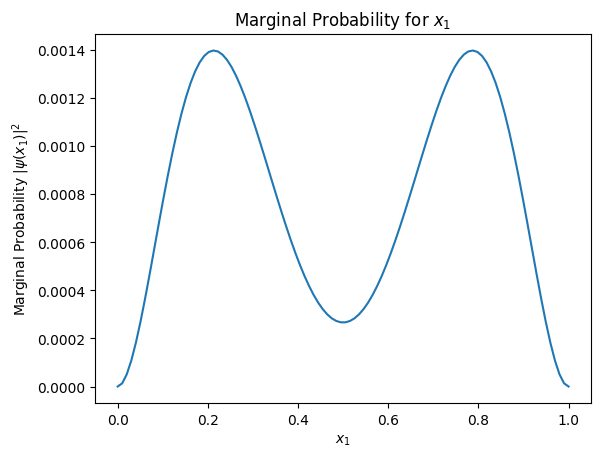

In [138]:
from scipy.integrate import simps

# Compute psi_T over a grid
x1 = np.linspace(0, L, 100)
x2 = np.linspace(0, L, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
psi_squared = psi_T(x1_grid, x2_grid, gamma)**2

# Integrate out x2
psi_marginal = simps(psi_squared, x2, axis=1)

# Plot marginal probability
plt.plot(x1, psi_marginal)
plt.xlabel('$x_1$')
plt.ylabel('Marginal Probability $|\psi(x_1)|^2$')
plt.title('Marginal Probability for $x_1$')
plt.show()


In [351]:
from scipy.optimize import minimize

# Define the objective function
def objective(beta):
    return mcs(gamma, beta)  # Replace with your Monte Carlo function

# Initial guess for gamma
beta_init = -1

# Minimize the energy
result = minimize(objective, gamma_init, method='Nelder-Mead')  # Use Nelder-Mead or similar
optimal_gamma = result.x[0]
print(f"Optimal gamma: {optimal_gamma}")


44.70719248174947
51.20997288580388
41.62645773912267
35.06914426850209
31.907161538886275
21.50817189698005
37.35370175072377
53.280409085439224
4.532240932370912
3.5640588107838815
94.41540513700821
96.43771085244335
4.684602164688013
4.060341882173546
6.595818312539433
3.720736033103199
3.8114126381985343
3.479544314934731
3.6583854532406375
3.6806403276047894
3.5837943125814995
3.8450603015414226
3.494246298693378
3.3894912757177127
3.4896627748826288
3.639298568095556
3.7850583951225265
3.516825572929945
3.621696789150607
3.5421582073328377
3.5914249453561435
3.622078467895422
3.388276761084585
3.4911067079789
3.68446039486309
3.9241072485014503
3.4358489980045905
3.943026744494382
3.453223924101383
3.368339460443512
3.6880138947748233
3.607925843967451
3.419932335224369
3.445640400806863
3.659595868946595
3.687208114878913
3.658054302269479
3.653440333661371
3.6197214422995647
3.647111610690868
3.520290834947798
3.4846125884971526
3.648528612819936
3.8054804443572827
3.6808235124

KeyboardInterrupt: 